importing useful libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

importing file

In [2]:
# !rm *.csv

#from google.colab import files
# print("Please load the raw csv data")
# uploadedData = files.upload()
# filename = list(uploadedData)[0]

reading the data from the file

In [3]:
#import file
filename = 'Preprocessed_Data.csv'

In [4]:
dataset = pd.read_csv(filename)

checking the data

In [5]:
dataset.shape

(1250, 26)

Formatting for texts and plots

In [6]:

from matplotlib import pylab
params = {'xtick.labelsize': 18,
          'ytick.labelsize': 18,
          'axes.titlesize' : 22,
          'axes.labelsize' : 20,
          'legend.fontsize': 18,
          'legend.title_fontsize': 22,
          'figure.titlesize': 24 }
pylab.rcParams.update(params)


splitting the data

In [7]:
from sklearn.model_selection import train_test_split
sum_of_last_2_digits_IDS=98
train_set , test_set = train_test_split(dataset, test_size=0.2, random_state=sum_of_last_2_digits_IDS)

In [33]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np

class SoftSVM(BaseEstimator, ClassifierMixin):
    """
    Custom C-Support Vector Classification.
    """
    def __init__(self, C: float, lr: float = 1e-5, batch_size = 32):
        """
        Initialize an instance of this class.
        ** Do not edit this method **

        :param C: inverse strength of regularization. Must be strictly positive.
        :param lr: the SGD learning rate (step size)
        """
        self.C = C
        self.lr = lr
        self.batch_size = batch_size
        self.w = None
        self.b = 0.0

    # Initialize a random weight vector
    def init_solution(self, n_features: int):
        """
        Randomize an initial solution (weight vector)
        ** Do not edit this method **

        :param n_features:
        """
        self.w = np.random.randn(n_features)
        self.b = 0.0

    @staticmethod
    def loss(w, b: float, C: float, X, y):
        """
        Compute the SVM objective loss.

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: the Soft SVM objective loss (float scalar)
        """
        margins = (X.dot(w) + b).reshape(-1, 1)
        hinge_inputs = np.multiply(margins, y.reshape(-1, 1))

        norm = np.linalg.norm(w)
        hinge_loss = np.maximum(1 - hinge_inputs, 0)
        hinge_loss_sum = np.sum(hinge_loss)
        loss=  norm ** 2 + C * hinge_loss_sum
        return loss

    @staticmethod
    def subgradient(w, b: float, C: float, X, y):
        """
        Compute the (analytical) SVM objective sub-gradient.

        :param w: weight vector for linear classification; array of shape (n_features,)
        :param b: bias scalar for linear classification
        :param C: inverse strength of regularization. Must be strictly positive.
        :param X: samples for loss computation; array of shape (n_samples, n_features)
        :param y: targets for loss computation; array of shape (n_samples,)
        :return: a tuple with (the gradient of the weights, the gradient of the bias)
        """
        # TODO: calculate the analytical sub-gradient of soft-SVM w.r.t w and b
        #g_w = 2w +C * sum f(y_i(w^T x_i + b) ) * y_i * x_i where f(z) = -1 if z < 1 else 0
        #g_b = C * sum f(y_i(w^T x_i + b)) * y_i
        margins = (X.dot(w) + b).reshape(-1, 1)
        z= np.multiply(margins, y.reshape(-1, 1))
        f = np.where(z < 1, -1, 0)
        g_w = 2*w + C * np.sum(f * y.reshape(-1, 1) * X, axis=0)
        g_b = C * np.sum(f * y.reshape(-1, 1))
        return g_w, g_b
        
        

    def fit_with_logs(self, X, y, max_iter: int = 2000, keep_losses: bool = True):
        """
        Fit the model according to the given training data.

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets (+1 and -1); array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        :param keep_losses:
        :return: the training losses and accuracies during training
        """
        # Initialize learned parameters
        self.init_solution(X.shape[1])

        losses = []
        accuracies = []

        if keep_losses:
            losses.append(self.loss(self.w, self.b, self.C, X, y))
            accuracies.append(self.score(X, y))

        permutation = np.random.permutation(len(y))
        X = X[permutation, :]
        y = y[permutation]

        # Iterate over batches
        for iter in range(0, max_iter):
            start_idx = (iter * self.batch_size) % X.shape[0]
            end_idx = min(X.shape[0], start_idx + self.batch_size)
            batch_X = X[start_idx:end_idx, :]
            batch_y = y[start_idx:end_idx]

            # TODO: Compute the (sub)gradient of the current *batch*
            g_w, g_b = self.subgradient(self.w, self.b, self.C, batch_X, batch_y)

            # Perform a (sub)gradient step
            # TODO: update the learned parameters correctly
            self.w = self.w - self.lr * g_w
            self.b = self.b - self.lr * g_b

            if keep_losses:
                losses.append(self.loss(self.w, self.b, self.C, X, y))
                accuracies.append(self.score(X, y))

        return losses, accuracies

    def fit(self, X, y, max_iter: int = 2000):
        """
        Fit the model according to the given training data.
        ** Do not edit this method **

        :param X: training samples; array of shape (n_samples, n_features)
        :param y: training targets (+1 and -1); array of shape (n_samples,)
        :param max_iter: number of SGD iterations
        """
        self.fit_with_logs(X, y, max_iter=max_iter, keep_losses=False)

        return self

    def predict(self, X):
        """
        Perform classification on samples in X.

        :param X: samples for prediction; array of shape (n_samples, n_features)
        :return: Predicted class labels for samples in X; array of shape (n_samples,)
                 NOTE: the labels must be either +1 or -1
        """
        # TODO: compute the predicted labels (+1 or -1)
        
        y_pred = np.sign(X.dot(self.w) + self.b)
        return y_pred
        
        
        


In [9]:
def visualize_clf(clf, X, Y, title,
                  xlabel, ylabel,
                  marker_size=50,
                  grid_length=300,
                  linewidths=None):
    import matplotlib.pyplot as plt
    import pandas as pd
    from matplotlib.colors import ListedColormap

    if isinstance(X, pd.DataFrame):
        X = X.to_numpy()

    # For internal use here, make sure labels are 0 and 1
    Y = np.ravel(Y).astype(int)
    labels = set(Y)
    assert len(labels) == 2, "Can only visualize two unique labels"

    if labels == set([-1,1]):
      Y = (Y + 1) // 2
      labels = set(Y)

    assert labels == set([0,1]), "Could not handle given labels"

    plt.figure(figsize=(8, 8))

    # Parameters
    n_classes = 2
    markers = ["D", "o"]
    palette = sns.color_palette("hls", 2)
    custom_cmap = ListedColormap(palette.as_hex())

    x_delta = np.abs(X[:, 0].max() - X[:, 0].min()) * 0.1
    y_delta = np.abs(X[:, 1].max() - X[:, 1].min()) * 0.1
    x_min, x_max = X[:, 0].min() - x_delta, X[:, 0].max() + x_delta
    y_min, y_max = X[:, 1].min() - y_delta, X[:, 1].max() + y_delta
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, grid_length),
                         np.linspace(y_min, y_max, grid_length))
    plt.tight_layout(h_pad=0.5, w_pad=0.5, pad=2.5)

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    cs = plt.contourf(xx, yy, Z, cmap=custom_cmap, alpha=0.35)

    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.grid(alpha=0.75)

    # Plot the training points
    for i, color, marker in zip(labels, palette, markers):
        idx = np.where(Y == i)
        plt.scatter(X[idx, 0], X[idx, 1], color=color,
                    marker=marker,
                    edgecolor='white', s=marker_size,
                    linewidths=linewidths)

    plt.title(title, fontsize=20)
    plt.axis("tight")
    plt.show()


In [10]:
def numerical_subgradient(w, b, C, X, y, delta=1e-4):
    w_ = w.copy()
    g_w = np.zeros_like(w_)
    orig_objective = SoftSVM.loss(w_, b, C, X, y)
    for i in range(g_w.shape[0]):
        w_[i] += delta
        perturbed_objective = SoftSVM.loss(w_, b, C, X, y)
        w_[i] -= delta
        g_w[i] = (perturbed_objective - orig_objective) / delta

    g_b = (SoftSVM.loss(w_, b + delta, C, X, y) - orig_objective) / delta
    return g_w, g_b



def compare_gradients(X, y, deltas, C=1, REPEATS=100, figsize=(10, 6)):
    residual_means = []

    for delta in deltas:
        residuals = []

        for _ in range(REPEATS):
            # Randomize vectors in which the gradient is computed
            w = np.random.randn(X.shape[1])
            b = np.random.randn(1)

            # Compute the two types of gradients
            analytic_grad = SoftSVM.subgradient(w, b, C, X, y)[0]
            numeric_grad = numerical_subgradient(w, b, C, X, y, delta=delta)[0]

            residual = np.linalg.norm(numeric_grad - analytic_grad)
            residuals.append(residual)

        residual_means.append(np.mean(residuals))

    plt.figure(figsize=figsize)
    plt.title('Residuals of analytical and numerical gradients', fontsize=22)
    plt.plot(deltas, residual_means, linewidth=3)
    plt.yscale('log')
    plt.xscale('log')
    plt.xlabel('$\delta$', fontsize=18)
    plt.ylabel(r'$\left\Vert \nabla_{w}p_{C}\left(w,b\right) - u_{\delta} \left(w,b\right)\right\Vert$', fontsize=18)

    plt.grid(alpha=0.5)
    plt.show()


C:\Users\t-darnissan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


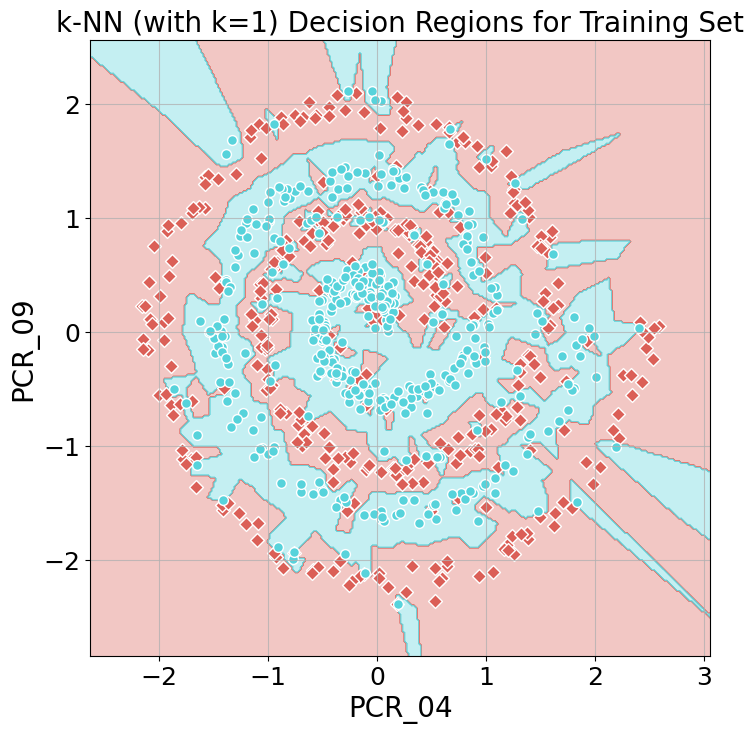

In [11]:
#start from here
'''Q1'''
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap




copy_of_train_set=train_set.copy()
temp_df = copy_of_train_set.drop(columns=['patient_id', 'current_location'])

#features and target
Q1_X = temp_df[['PCR_04', 'PCR_09']]
Q1_y = temp_df['spread']
# Split the dataset into training and testing sets
Q1X_train, Q1X_test, Q1y_train, Q1y_test = train_test_split(Q1_X,   Q1_y, test_size=0.2, random_state=sum_of_last_2_digits_IDS)



# Create and train the k-NN classifier with k=1
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(Q1X_train, Q1y_train)

# Visualize the decision regions
visualize_clf(knn, Q1X_train, Q1y_train, title='k-NN (with k=1) Decision Regions for Training Set',
              xlabel='PCR_04', ylabel='PCR_09')

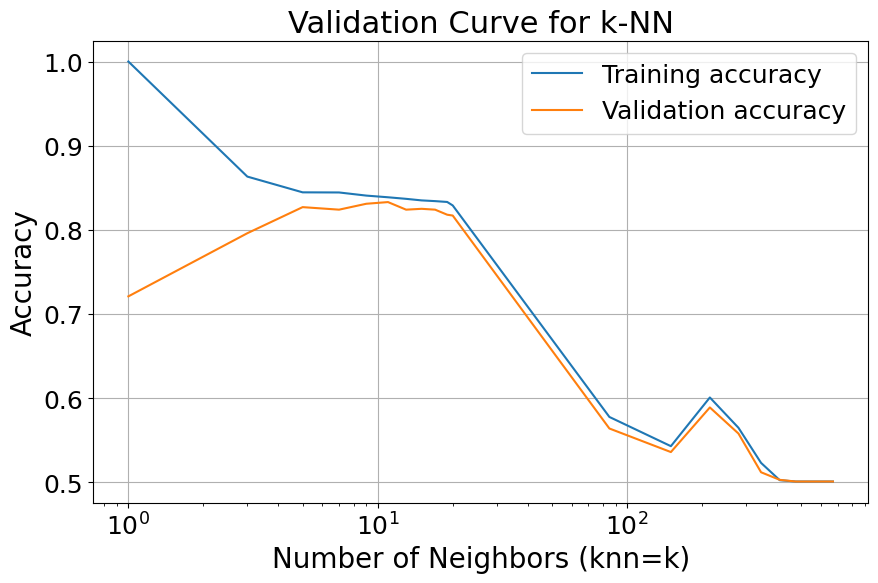

Best k: 11
Average training accuracy for best k: 0.8387142857142857
Average validation accuracy for best k: 0.833


In [12]:
'''Q2'''
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
# Define the range of k values to test
k_values = list(range(1, 20, 2)) + list(range(20, 695, 65))

# Perform cross-validation for each k value
train_scores = []
valid_scores = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k)
    cv_results = cross_validate(knn, Q1_X, Q1_y, cv=8, return_train_score=True)
    train_scores.append(np.mean(cv_results['train_score']))
    valid_scores.append(np.mean(cv_results['test_score']))

# Plot the validation curve
plt.figure(figsize=(10, 6))
plt.semilogx(k_values, train_scores, label='Training accuracy')
plt.semilogx(k_values, valid_scores, label='Validation accuracy')
plt.xlabel('Number of Neighbors (knn=k)')
plt.ylabel('Accuracy')
plt.title('Validation Curve for k-NN')
plt.legend()
plt.grid(True)
plt.show()

# Find the best k value
best_k = k_values[np.argmax(valid_scores)]
best_train_accuracy = train_scores[np.argmax(valid_scores)]
best_valid_accuracy = valid_scores[np.argmax(valid_scores)]

print(f'Best k: {best_k}')
print(f'Average training accuracy for best k: {best_train_accuracy}')
print(f'Average validation accuracy for best k: {best_valid_accuracy}')

In [13]:
optimal_k = best_k  # Replace with the optimal k found from the previous step
knn_optimal = KNeighborsClassifier(n_neighbors=optimal_k)
knn_optimal.fit(Q1X_train, Q1y_train)



KNeighborsClassifier(n_neighbors=11)

In [14]:
test_accuracy = knn_optimal.score(Q1X_test, Q1y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")


Test Accuracy: 0.8150


C:\Users\t-darnissan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but KNeighborsClassifier was fitted with feature names
  warnings.warn(


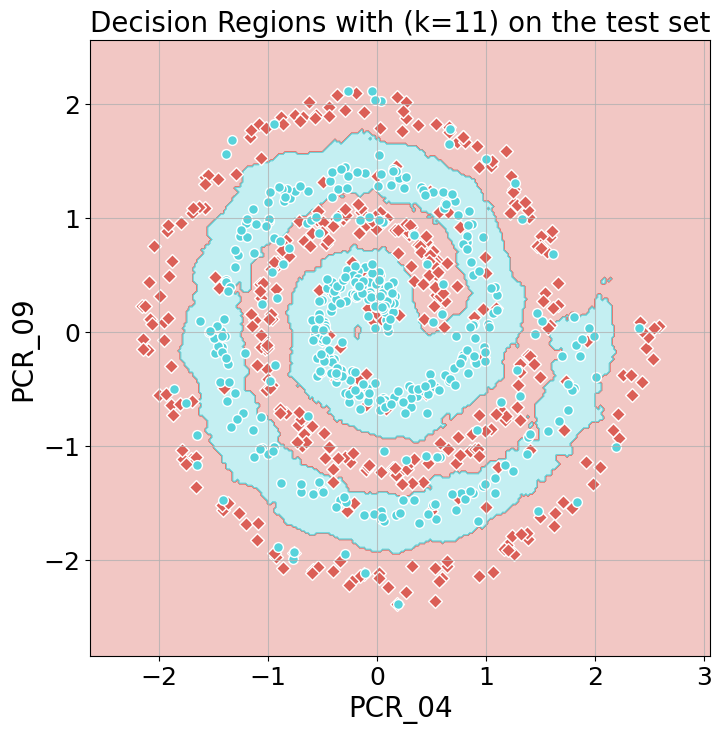

In [15]:
visualize_clf(knn_optimal, Q1X_train, Q1y_train, title=f'Decision Regions with (k={optimal_k}) on the test set',xlabel='PCR_04',ylabel='PCR_09')

Part 2 Decision Trees 
-in this part we will be using PCR_03 and PCR_10 and blood_type (use it the same as in
major hw1, split it into two groups: {O+, B+} and {O-, A-, A+, B-, AB+, AB-}) to predict
the risk class using decision trees
-Rather than implementing the models by yourself, you will
use sklearn’s DecisionTreeClassifier with entropy as a splitting criterion (ID3) and focus on
hyperparameter tuning and visualization. 

In [16]:
part2_train_set = train_set.copy()
# include only pcr_03 ,pcr_10 and split bloodtype to {O+,B+} and {O-,A-,A+,B-,AB+,AB-}
part2_train_set['SpecialProperty'] = part2_train_set['blood_type'].isin(['O+', 'B+'])
part2_train_set.drop(columns=['blood_type'], inplace=True)
part2_train_set = part2_train_set[['PCR_03', 'PCR_10', 'SpecialProperty', 'risk']]
part2_train_set.head()

,PCR_03,PCR_10,SpecialProperty,risk
835,0.121168,-0.286942,False,-1
214,-0.152016,0.735570,False,-1
549,0.474149,0.728434,False,1
1093,-0.888642,0.456493,False,-1
687,0.522467,0.013915,False,-1


Training Accuracy: 0.66


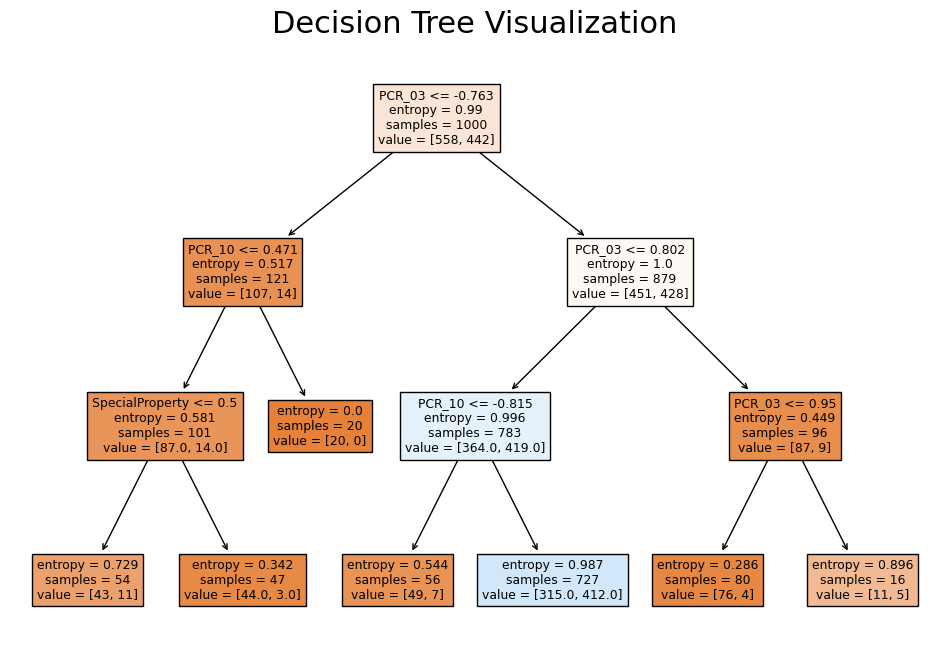

In [17]:
'''Q5'''
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree
import matplotlib.pyplot as plt



# Separate the features and target
Q5X = part2_train_set[['PCR_03', 'PCR_10', 'SpecialProperty']]
Q5y = part2_train_set['risk']

# Train the decision tree model with max_depth=3
model = DecisionTreeClassifier(criterion='entropy', max_depth=3)
model.fit(Q5X, Q5y)

# Compute the training accuracy
train_accuracy = model.score(Q5X, Q5y)
print(f'Training Accuracy: {train_accuracy:.2f}')

# Visualize the decision tree
plt.figure(figsize=(12, 8))
plot_tree(model,feature_names=Q5X.columns ,filled=True)
plt.title('Decision Tree Visualization')
plt.savefig('decision_tree.png')
plt.show()

Q6

Model selection
It is time to search for the best tree to fight covid! Using the DecisionTreeClassifier
documentation, understand how the min_samples_leaf argument can mitigate overfitting.
You will now tune two hyperparameters simultaneously – both min_samples_leaf and
max_depth. You need to look for the combination of these two hyperparameters that lead to
the best validation performance. There are many approaches for tuning multiple
hyperparameters, and here we take the grid search approach (shortly explained here).
(Q6) Using 5-fold cross-validation, tune the two hyperparameters by performing a grid search
(see GridSearchCV). Find the combination yielding the best validation error for
predicting the risk class


In [18]:
Q5y.head()

835    -1
214    -1
549     1
1093   -1
687    -1
Name: risk, dtype: int64

In [19]:
from sklearn.model_selection import GridSearchCV
q6X= Q5X
q6y= Q5y
param_dict={'min_samples_leaf': list(range(1,20,2)),'max_depth': list(range(1, 20, 2))}
model = DecisionTreeClassifier(criterion='entropy')
grid_search = GridSearchCV(estimator= model,param_grid= param_dict, cv=5, n_jobs=-1,scoring='accuracy',return_train_score=True)
_=grid_search.fit(q6X, q6y)
print("Best parameters found: ", grid_search.best_params_)
print("Best accuracy found: ", grid_search.best_score_)
print("Best estimator found: ", grid_search.best_estimator_)



Best parameters found:  {'max_depth': 13, 'min_samples_leaf': 9}
Best accuracy found:  0.8220000000000001
Best estimator found:  DecisionTreeClassifier(criterion='entropy', max_depth=13, min_samples_leaf=9)


Since we tune two hyperparameters, instead of
a validation curve, plot two heatmaps (seaborn
/ pyplot), for each of the cross-validated training
and validation accuracy (the heatmaps should
roughly look like the ones to the right).
Plot the appropriate “ticks” on both axes and
use annotations (annot=True) to explicitly write accuracies inside heatmap cells.
Important: The plots should be readable and informative!

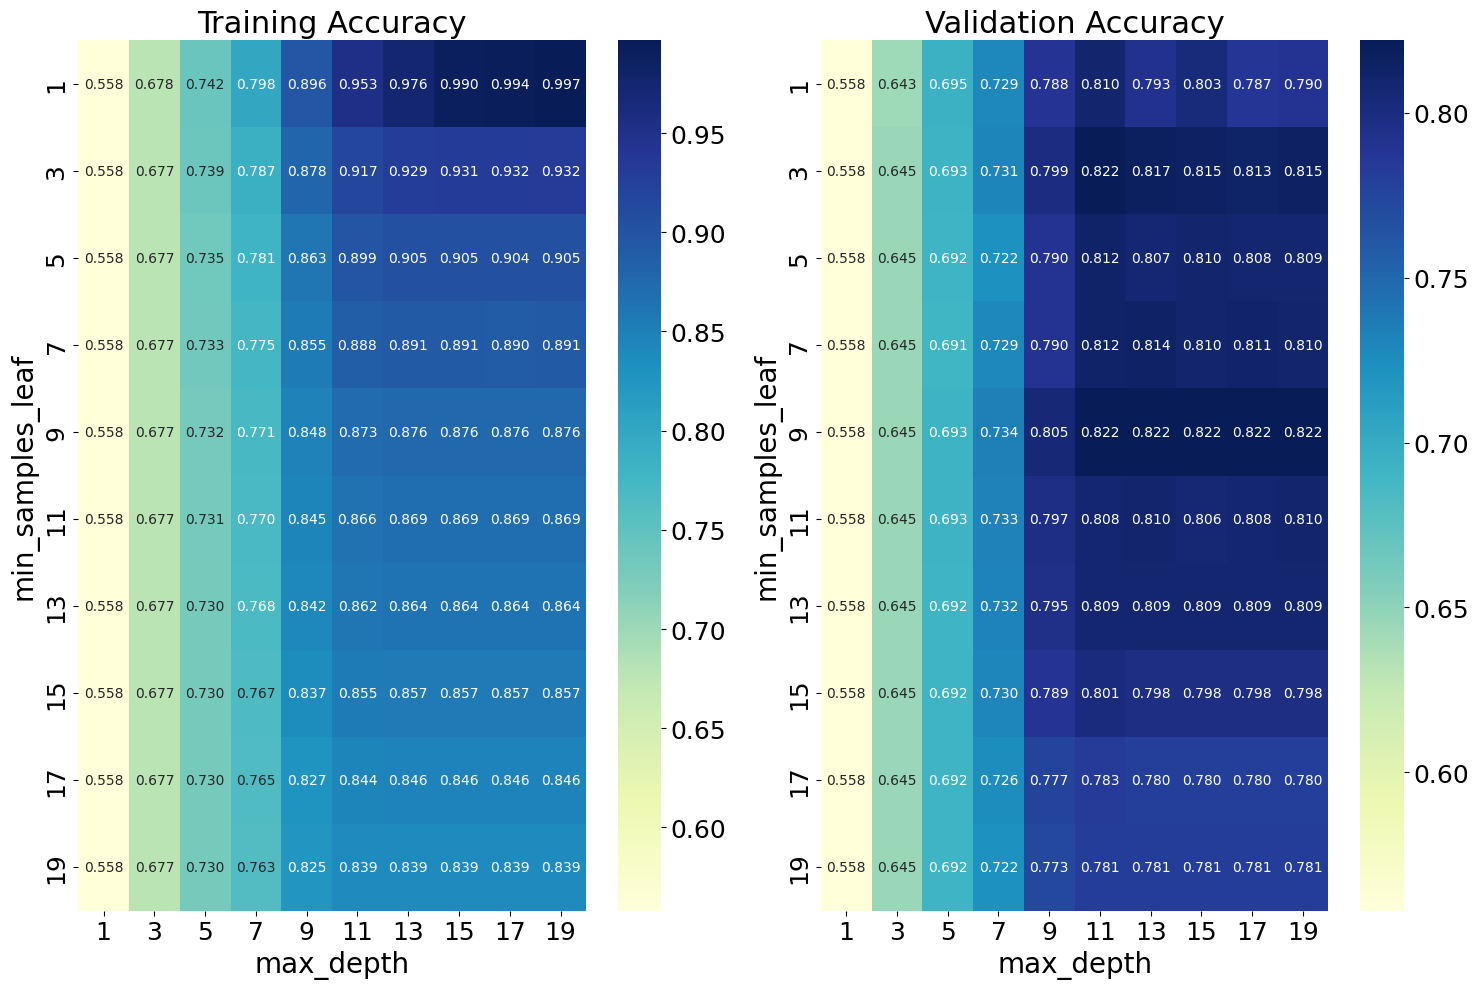

In [20]:
results= pd.DataFrame(grid_search.cv_results_)
train_scores = results.pivot(index="param_min_samples_leaf", columns="param_max_depth", values="mean_train_score")
test_scores = results.pivot(index="param_min_samples_leaf", columns="param_max_depth", values="mean_test_score")

plt.figure(figsize=(15, 10))

# Training accuracy heatmap
plt.subplot(1, 2, 1)
sns.heatmap(train_scores, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title('Training Accuracy')
plt.xlabel('max_depth')
plt.ylabel('min_samples_leaf')

# Validation accuracy heatmap
plt.subplot(1, 2, 2)
sns.heatmap(test_scores, annot=True, fmt=".3f", cmap="YlGnBu")
plt.title('Validation Accuracy')
plt.xlabel('max_depth')
plt.ylabel('min_samples_leaf')

plt.tight_layout()
plt.show()

In [21]:
'''Q8'''

from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split


q8_test_set = test_set.copy()
q8_test_set['SpecialProperty'] = q8_test_set['blood_type'].isin(['O+', 'B+'])  
q8x_test = q8_test_set[['PCR_03', 'PCR_10', 'SpecialProperty']]
q8y_test = q8_test_set['risk']
# Define the model with the optimal hyperparameters
optimal_model = DecisionTreeClassifier(max_depth=11, min_samples_leaf=9)

# Train the model on all the training samples
optimal_model.fit(q6X, q6y)

# Predict on the test set
y_pred = optimal_model.predict(q8x_test)

# Calculate the test accuracy
test_accuracy = accuracy_score(q8y_test, y_pred)

print(f"Test accuracy of the model with max_depth=11 and min_samples_leaf=9: {test_accuracy:.4f}")


Test accuracy of the model with max_depth=11 and min_samples_leaf=9: 0.8200


Using PCR_04, PCR_09, generate a plot that compares the numerical gradients to the
analytic gradients. Do this by running the following command:
Attach the plot to your report. Briefly discuss and justify the demonstrated behavior.


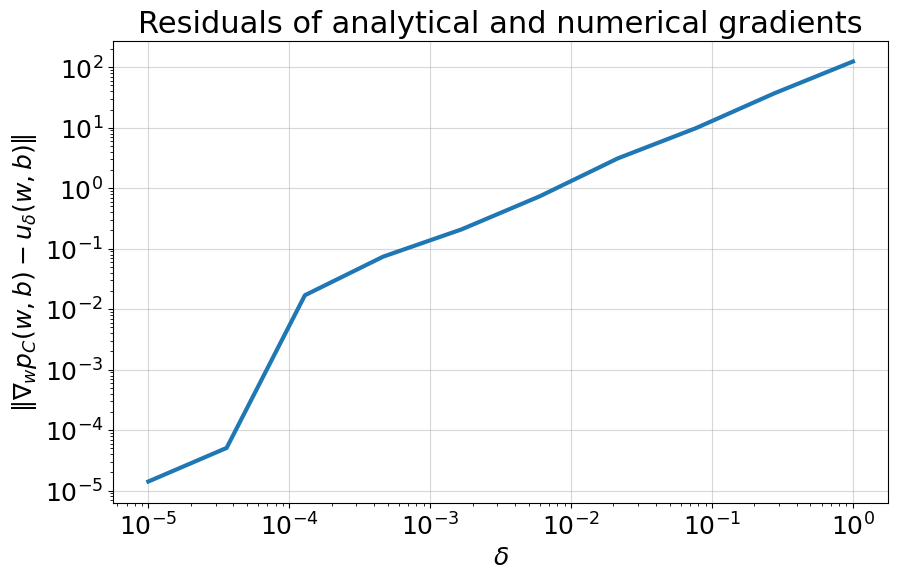

In [22]:
'''Q9'''
q9_train_set = train_set.copy()
q9_train_set = q9_train_set[['PCR_04', 'PCR_09', 'spread']]
q9x = q9_train_set[['PCR_04', 'PCR_09']]
q9y = q9_train_set['spread']
compare_gradients(q9x.to_numpy(), q9y.to_numpy(), deltas=np.logspace(-5, 0, 10))



The following snippet transforms the features, rescales them and then trains a SoftSVM
model and plots the learning curves. Plot the a graph for each learning rate in the
range np.logspace(-11, -3, 5) without changing the C value given below (if your
graphs don’t exhibit interesting phenomena, you may slightly modify the range, but
make sure C is 1e5 across all learning rates; in such a case, explicitly mention in the
following question that you changed the lr range)

C=1e5
clf = SoftSVM(C=C, lr=lr)
X_train_poly = PolynomialFeatures(degree=3,).fit_transform(X_train)
X_train_poly = MinMaxScaler(feature_range=(-1,1)).fit_transform(X_train_poly)
losses, accuracies = clf.fit_with_logs(X_train_poly, y_train, max_iter=5000)
plt.figure(figsize=(13, 6))
plt.subplot(121), plt.grid(alpha=0.5), plt.title ("Training Loss")
plt.semilogy(losses), plt.xlabel("Step"), plt.ylabel("Loss")
plt.subplot(122), plt.grid(alpha=0.5), plt.title ("Training Accuracy")
plt.plot(accuracies), plt.xlabel("Step"), plt.ylabel("Accuracy")
plt.tight_layout()
plt.show()

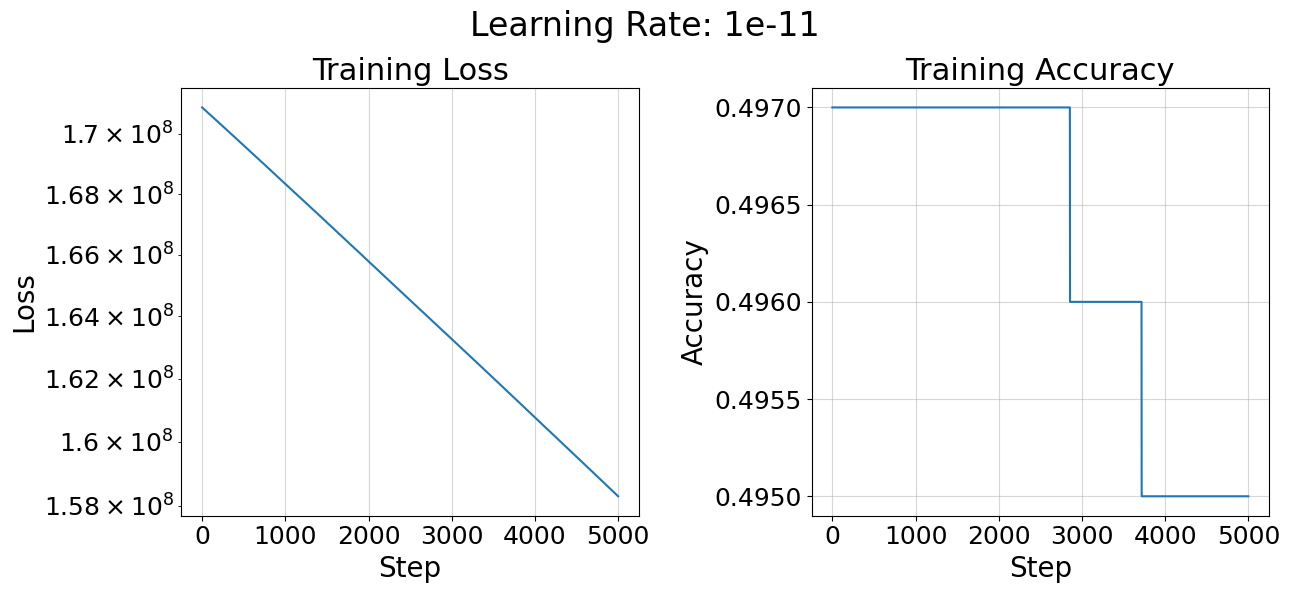

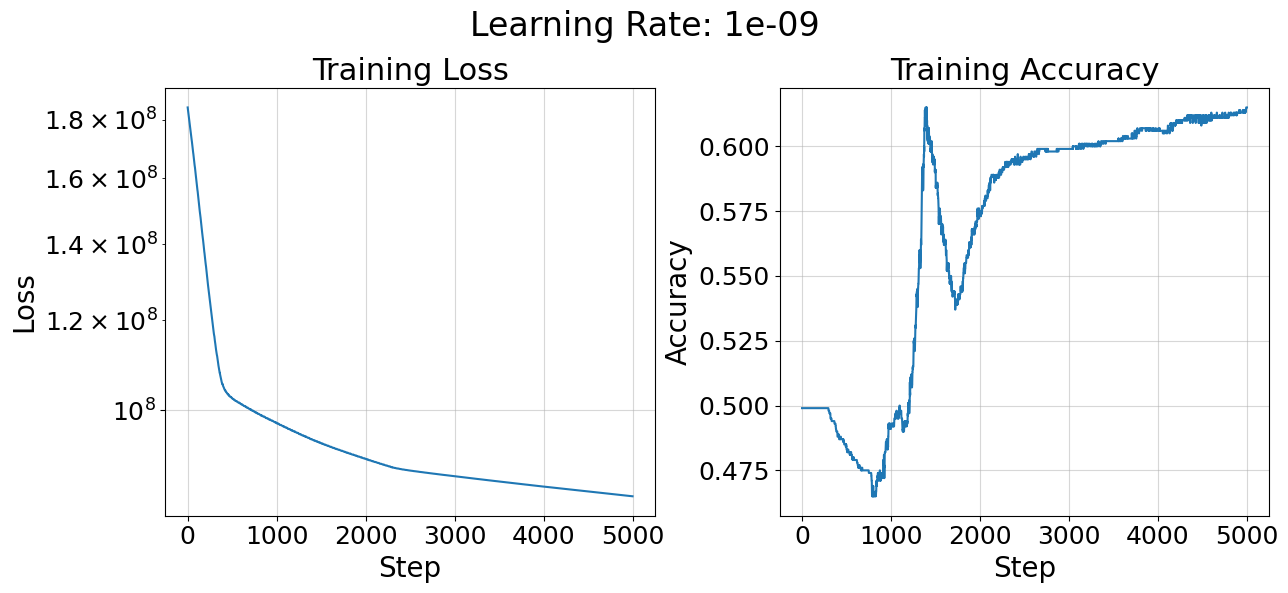

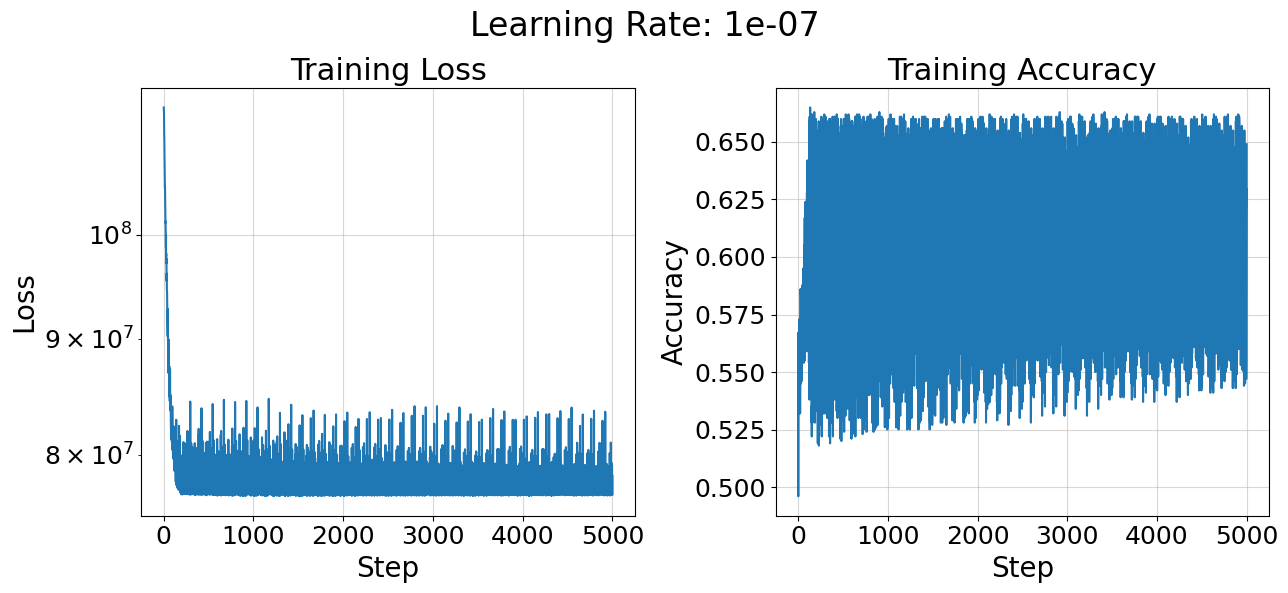

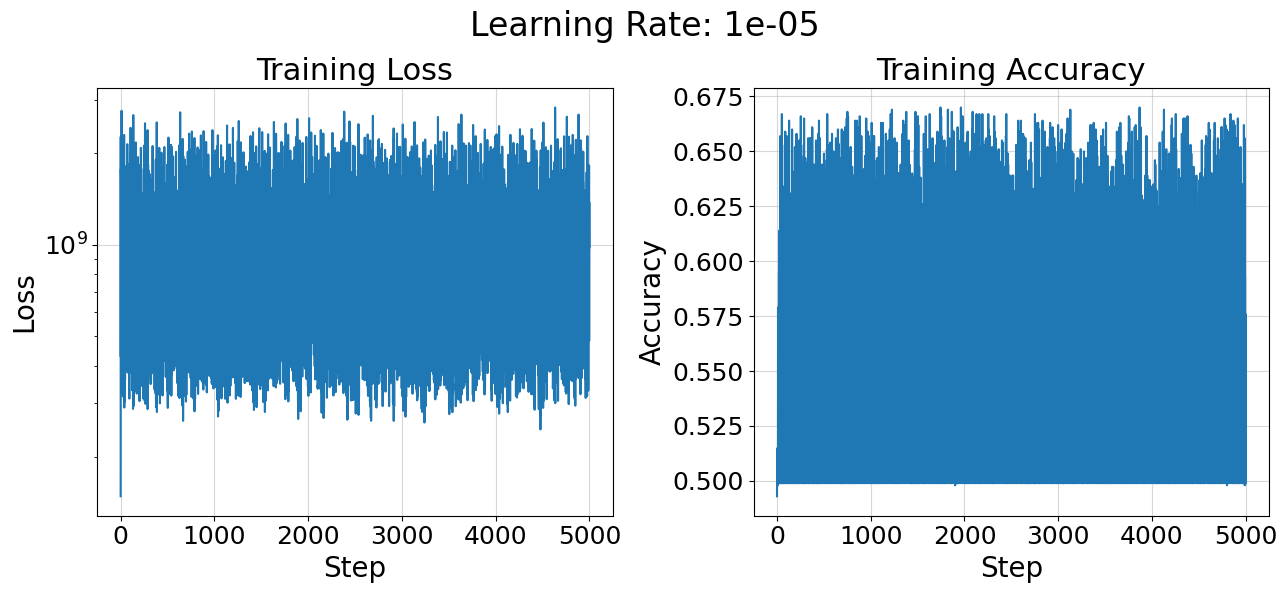

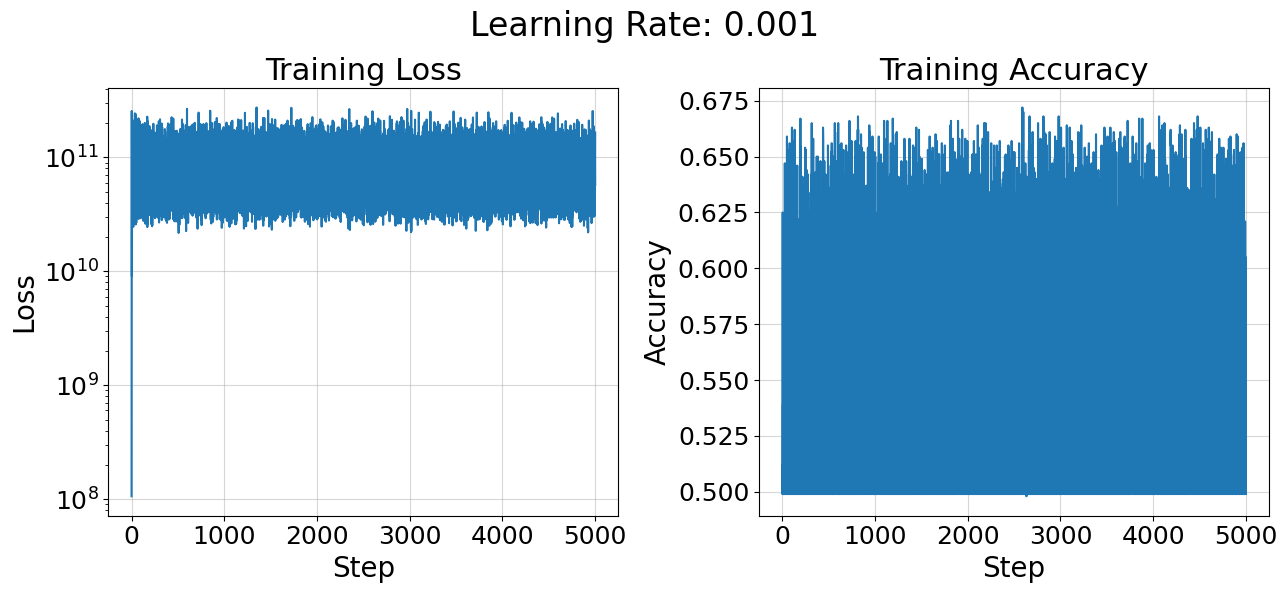

In [30]:
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
q11X_dataset= train_set.copy()
q11X_train= q11X_dataset[['PCR_04', 'PCR_09']]
q11y_train= q11X_dataset['spread'] 
q11X_train= np.array(q11X_train)
q11y_train= np.array(q11y_train)
C=1e5
for learning_rate in np.logspace(-11,-3,5):
    clf = SoftSVM(C=C, lr=learning_rate)
    X_train_poly = PolynomialFeatures(degree=3,).fit_transform(q11X_train)
    X_train_poly = MinMaxScaler(feature_range=(-1,1)).fit_transform(X_train_poly)
    losses, accuracies = clf.fit_with_logs(X_train_poly, q11y_train, max_iter=5000)
    plt.figure(figsize=(13, 6))
    plt.subplot(121), plt.grid(alpha=0.5), plt.title ("Training Loss")
    plt.semilogy(losses), plt.xlabel("Step"), plt.ylabel("Loss")
    plt.subplot(122), plt.grid(alpha=0.5), plt.title ("Training Accuracy")
    plt.plot(accuracies), plt.xlabel("Step"), plt.ylabel("Accuracy")
    plt.tight_layout()
    plt.suptitle(f"Learning Rate: {learning_rate}")
    plt.subplots_adjust(top=0.85)
    plt.show()

Task: Complete the pipeline above to make it apply a 3rd-degree PolynomialFeatures
transformation. Use the learning rate you chose in (Q11). Train the model.

In [41]:
from sklearn.preprocessing import MinMaxScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline


svm_clf = Pipeline([
    ('feature_mapping', PolynomialFeatures(degree=3)),
    ('scaler', MinMaxScaler()),
    ('SVM', SoftSVM(C=1e5, lr=1e-09))
])

svm_clf.fit(q11X_train, q11y_train, SVM__max_iter=5000)

Pipeline(steps=[('feature_mapping', PolynomialFeatures(degree=3)),
                ('scaler', MinMaxScaler()),
                ('SVM', SoftSVM(C=100000.0, lr=1e-09))])

Training accuracy: 0.5780
Test accuracy: 0.5640


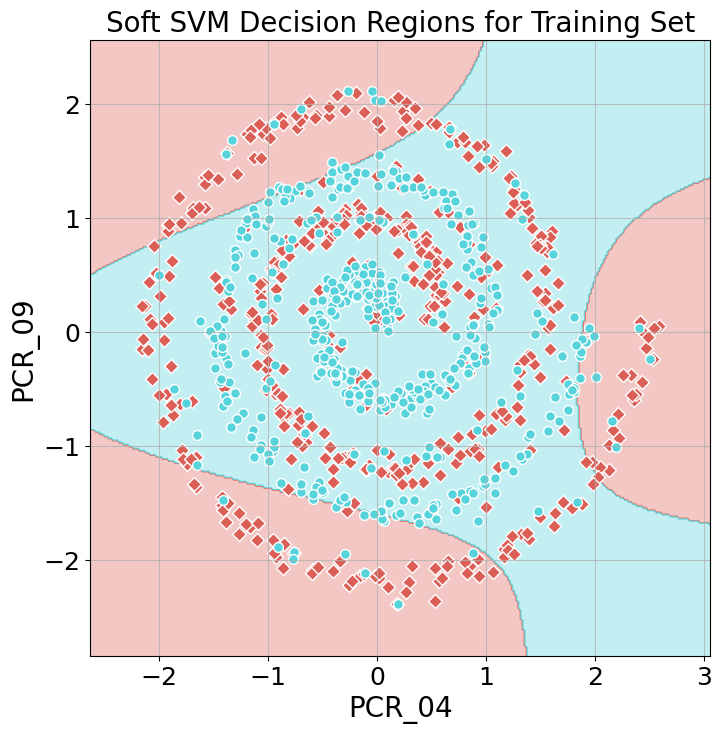

In [42]:
print(f"Training accuracy: {svm_clf.score(q11X_train, q11y_train):.4f}")
q11_test_set = test_set.copy()
q11X_test = q11_test_set[['PCR_04', 'PCR_09']]
q11y_test = q11_test_set['spread']
q11X_test = np.array(q11X_test)
q11y_test = np.array(q11y_test)
print(f"Test accuracy: {svm_clf.score(q11X_test, q11y_test):.4f}")
# Visualize the decision regions on PCR_04 and PCR_09
visualize_clf(svm_clf, q11X_train, q11y_train, title='Soft SVM Decision Regions for Training Set',
              xlabel='PCR_04', ylabel='PCR_09')